In [18]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys

## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

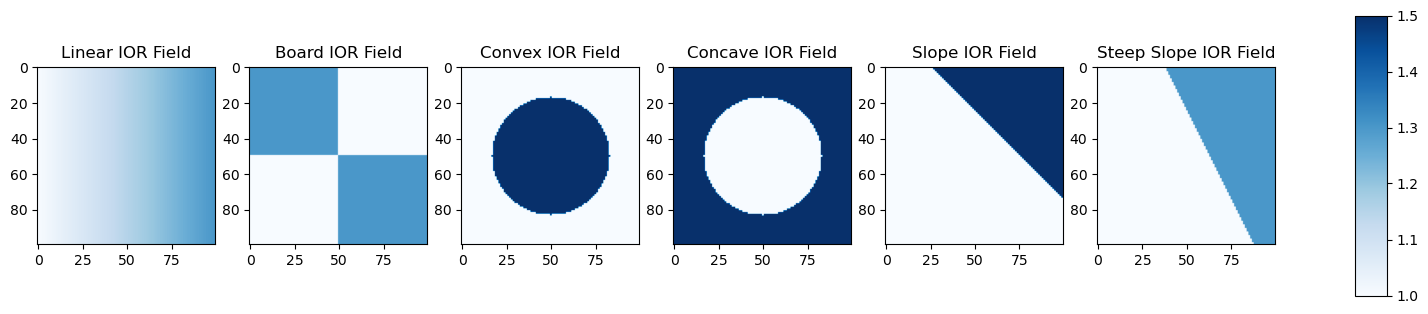

In [19]:
field_size = 100

height, width = field_size, field_size
gradient = np.linspace(0, 0.3, width, dtype=np.float32)
linear_ior_field = np.tile(gradient, (height, 1)) + 1

tile_size = int(field_size / 2)
board_ior_field = np.kron([[1, 0] * (width//tile_size//2),
                 [0, 1] * (width//tile_size//2)] * (height//tile_size//2),
                np.ones((tile_size, tile_size))) * 0.3 + 1.0

center = (height//2, width//2)
radius = int(field_size / 3) 
y, x = np.ogrid[:height, :width]
mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
convex_lens_ior_field = np.ones((height, width), dtype=np.float32)
convex_lens_ior_field[mask] = 1.5

concave_lens_ior_field = np.ones((height, width), dtype=np.float32) * 1.5
concave_lens_ior_field[mask] = 1.0


slope_ior_field = np.zeros((height, width), dtype=np.float32)
for y in range(height):
    for x in range(width):
        if y < x - int(field_size / 4):
            slope_ior_field[y, x] = 1.5
        else:
            slope_ior_field[y, x] = 1.0

steep_slope_ior_field = np.zeros((height, width), dtype=np.float32)
for y in range(height):
    for x in range(width):
        if y < 2 * x - int(field_size * 0.75):
            steep_slope_ior_field[y, x] = 1.3
        else:
            steep_slope_ior_field[y, x] = 1.0

plt.figure(figsize=(16, 4))

ior_fields = [linear_ior_field, board_ior_field, convex_lens_ior_field, concave_lens_ior_field, slope_ior_field, steep_slope_ior_field]
titles = ['Linear IOR Field', 'Board IOR Field', 'Convex IOR Field', 'Concave IOR Field', 'Slope IOR Field', 'Steep Slope IOR Field']

for i, field in enumerate(ior_fields, 1):
    plt.subplot(1, 6, i)
    plt.imshow(field, cmap='Blues', vmin=1.0, vmax=1.5)
    plt.title(titles[i - 1])

# Share the same colorbar
plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)

plt.show()

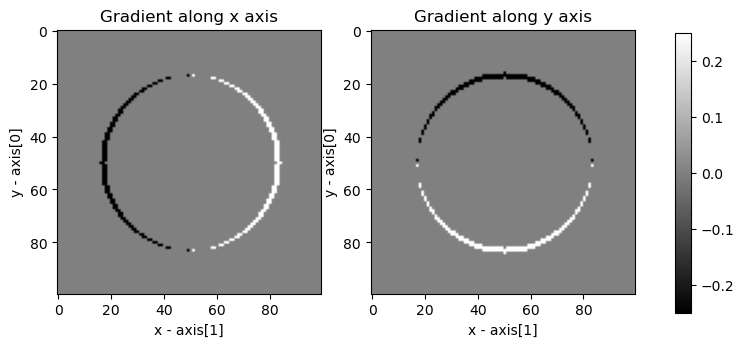

In [20]:
def compute_gradients(IOR):
    grad_x = np.gradient(IOR, axis=1)
    grad_y = np.gradient(IOR, axis=0)
    return grad_x, grad_y

grad_x, grad_y = compute_gradients(concave_lens_ior_field)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient along x axis')
plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.subplot(122)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient along y axis')

plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()

## 2. Update wavefront

In [21]:
initial_wavefront_positions = [(0, i) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1, 0) for _ in range(field_size)]  # initial directions are all to the right

num_steps = int(field_size * 5)
delta_t = 0.5
num_show_images = 5

ior_field_dict = {
    'linear': {'ior': linear_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'board': {'ior': board_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'convex_lens': {'ior': convex_lens_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'concave_lens': {'ior': concave_lens_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'slope': {'ior': slope_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'steep_slope': {'ior': steep_slope_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None}
}

In [22]:
class Patch:
    def __init__(self, start_pos: np.ndarray, end_pos: np.ndarray, energy: float):
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.energy = energy
    
    def mid_pos(self):
        return (self.start_pos + self.end_pos) / 2
    
    def length(self):
        return np.linalg.norm(self.end_pos - self.start_pos)
    
    def __repr__(self):
        return (f"Patch【start_pos{self.start_pos.tolist()}, "
                f"end_pos{self.end_pos.tolist()} | "
                f"mid_pos{self.mid_pos().tolist()} | "
                f"energy={self.energy}, "                
                f"length={self.length()}】")

initial_patches = [Patch(np.array([0, 0]), np.array([0, 1]), 1.0), 
                   Patch(np.array([0, 1]), np.array([0, 2]), 1.0)]

initial_patches

[Patch【start_pos[0, 0], end_pos[0, 1] | mid_pos[0.0, 0.5] | energy=1.0, length=1.0】,
 Patch【start_pos[0, 1], end_pos[0, 2] | mid_pos[0.0, 1.5] | energy=1.0, length=1.0】]

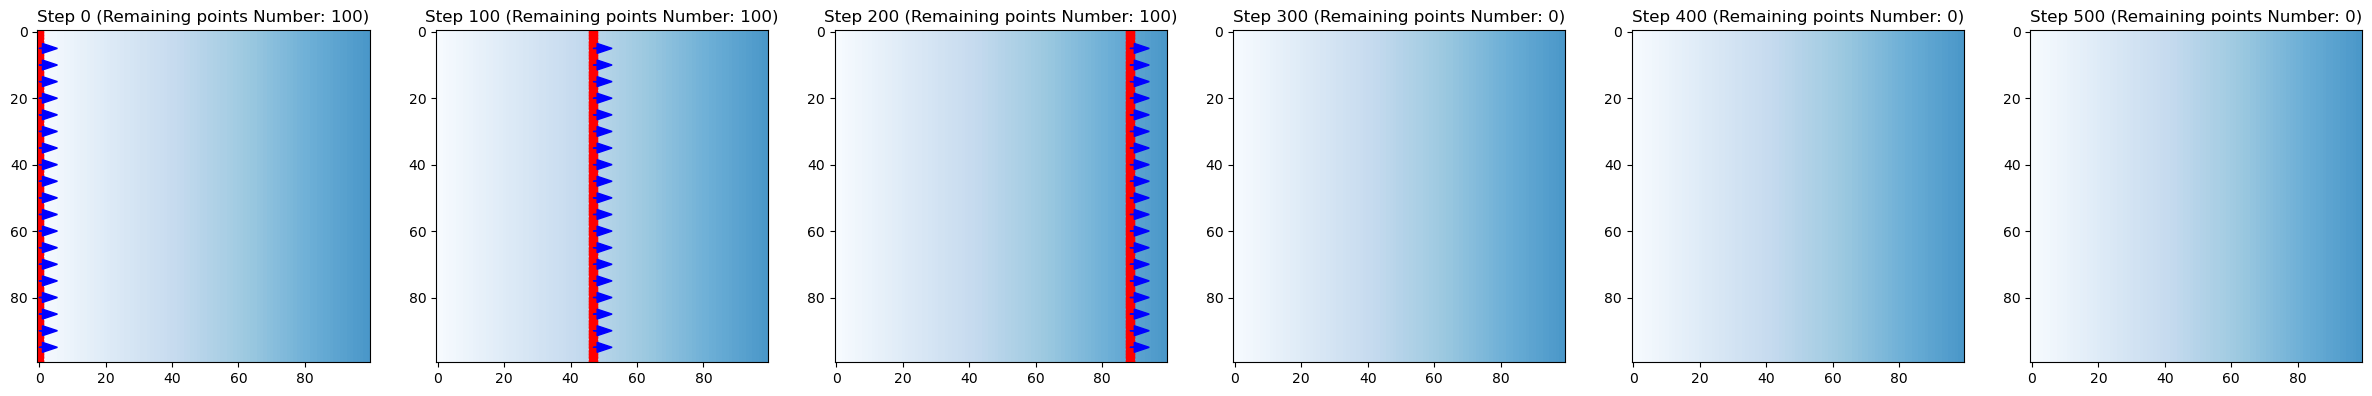

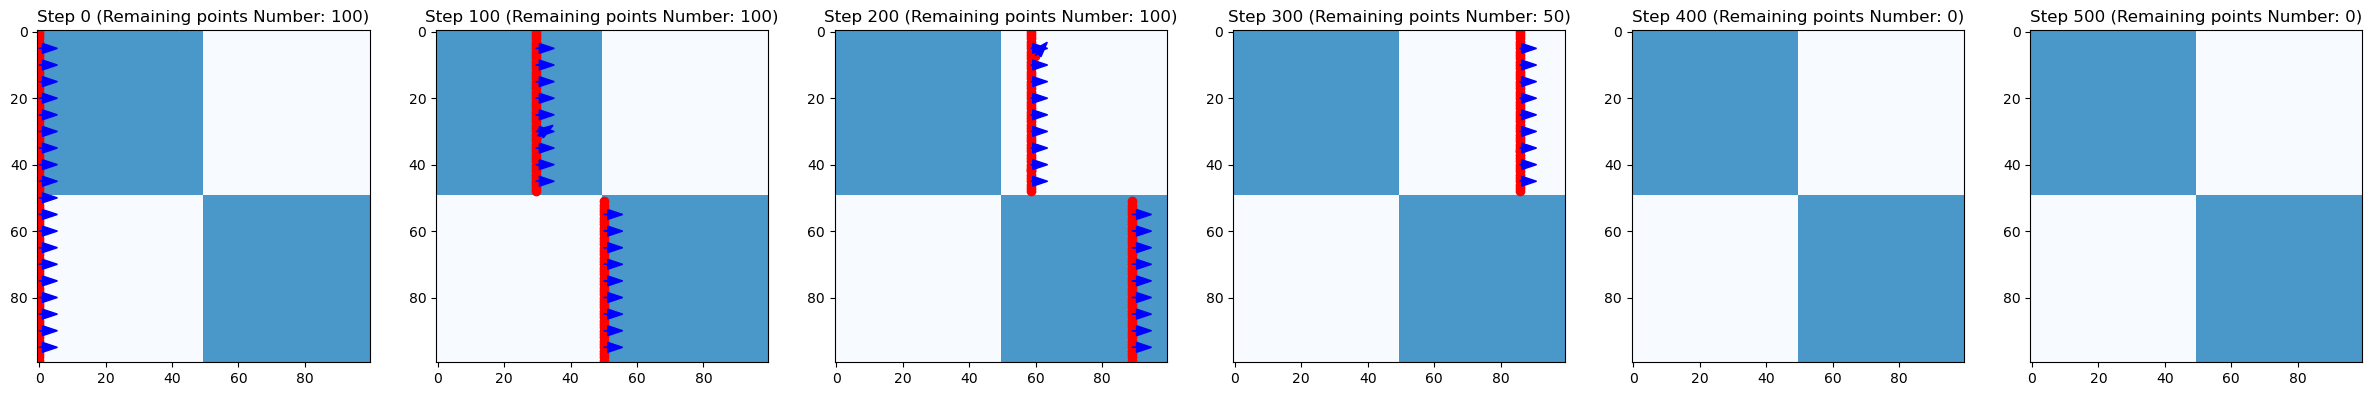

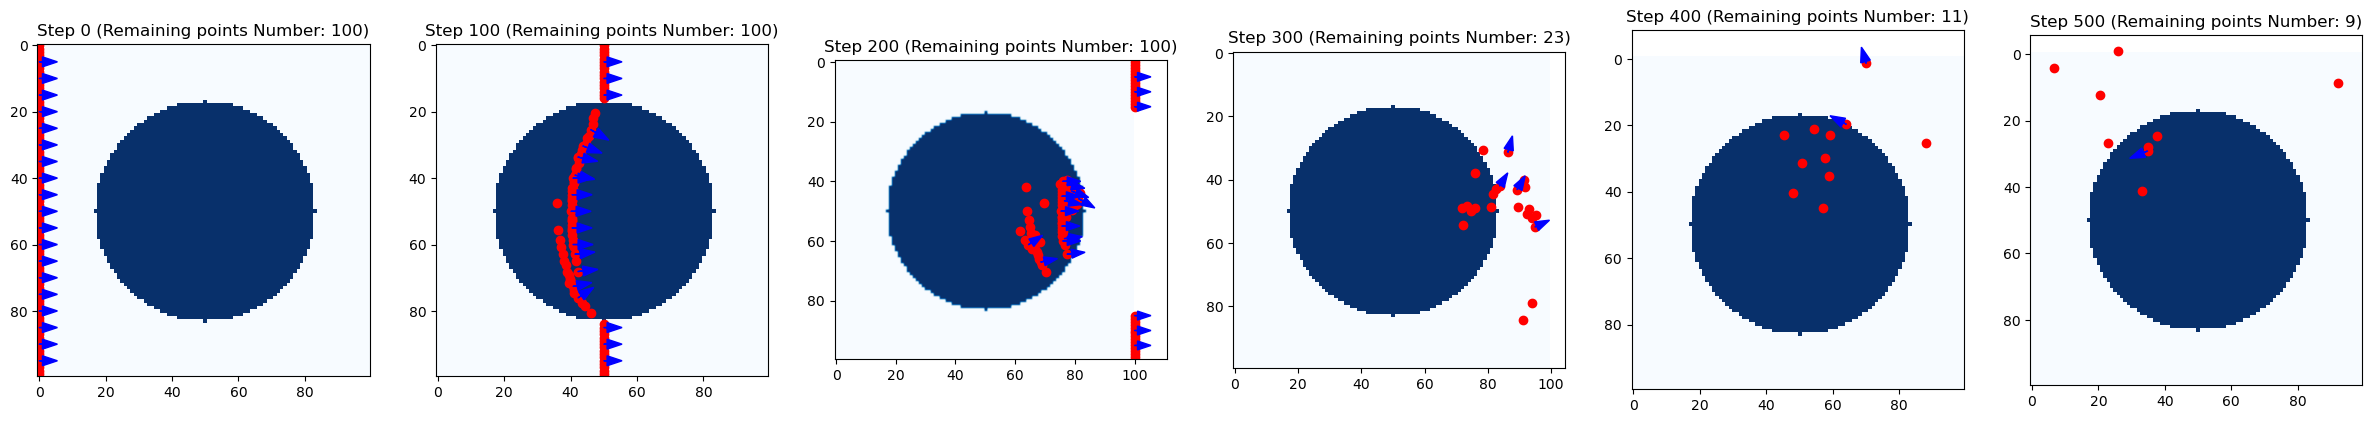

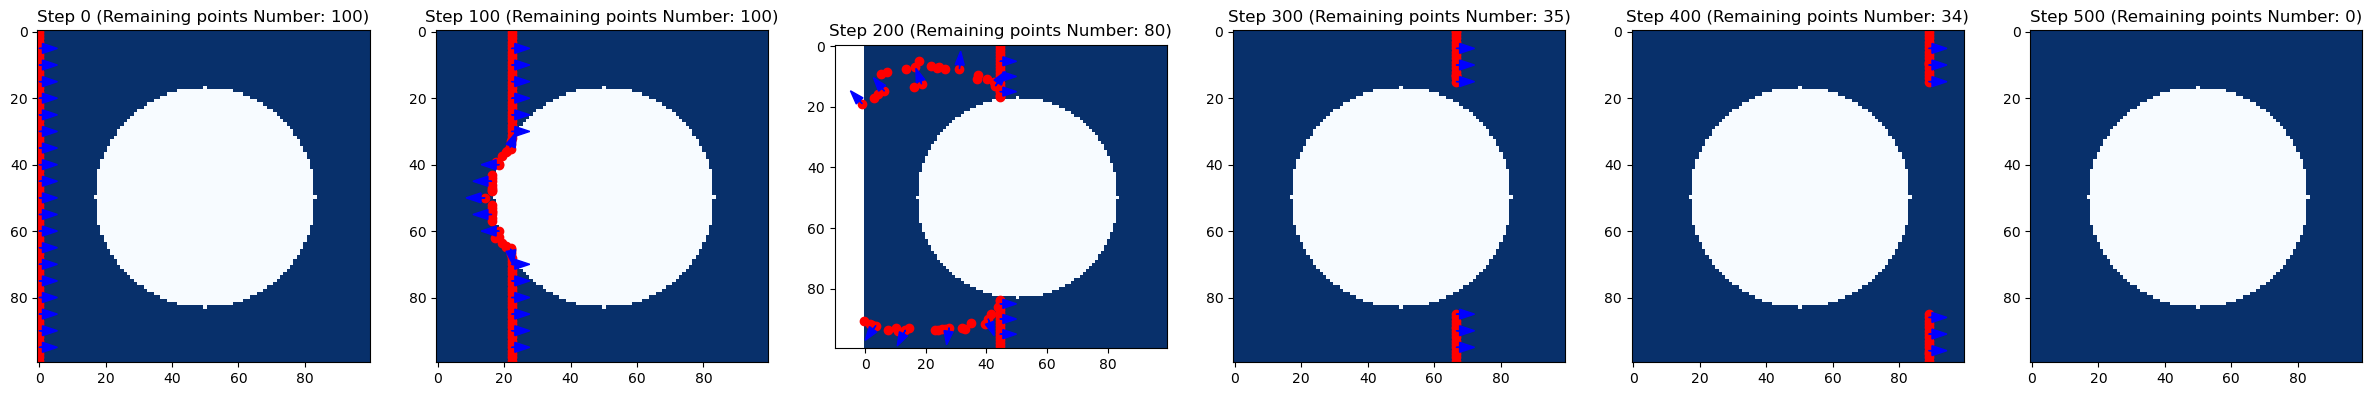

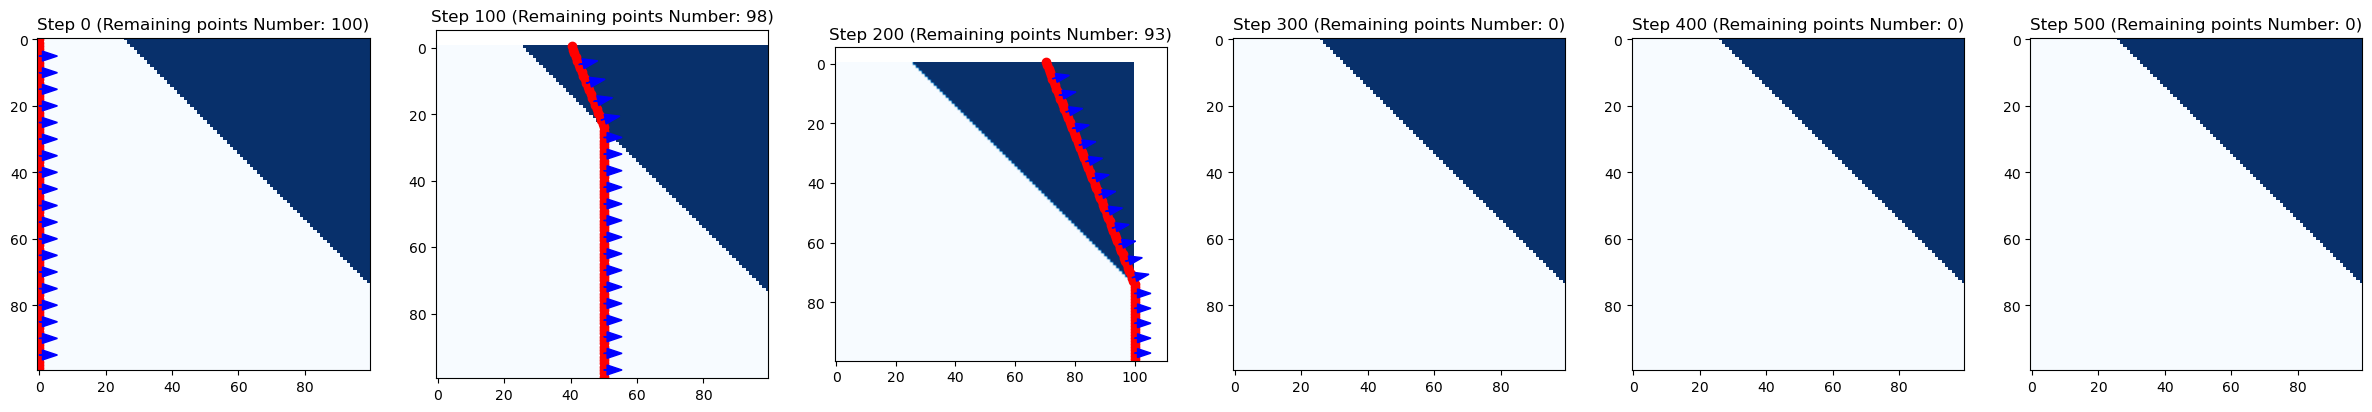

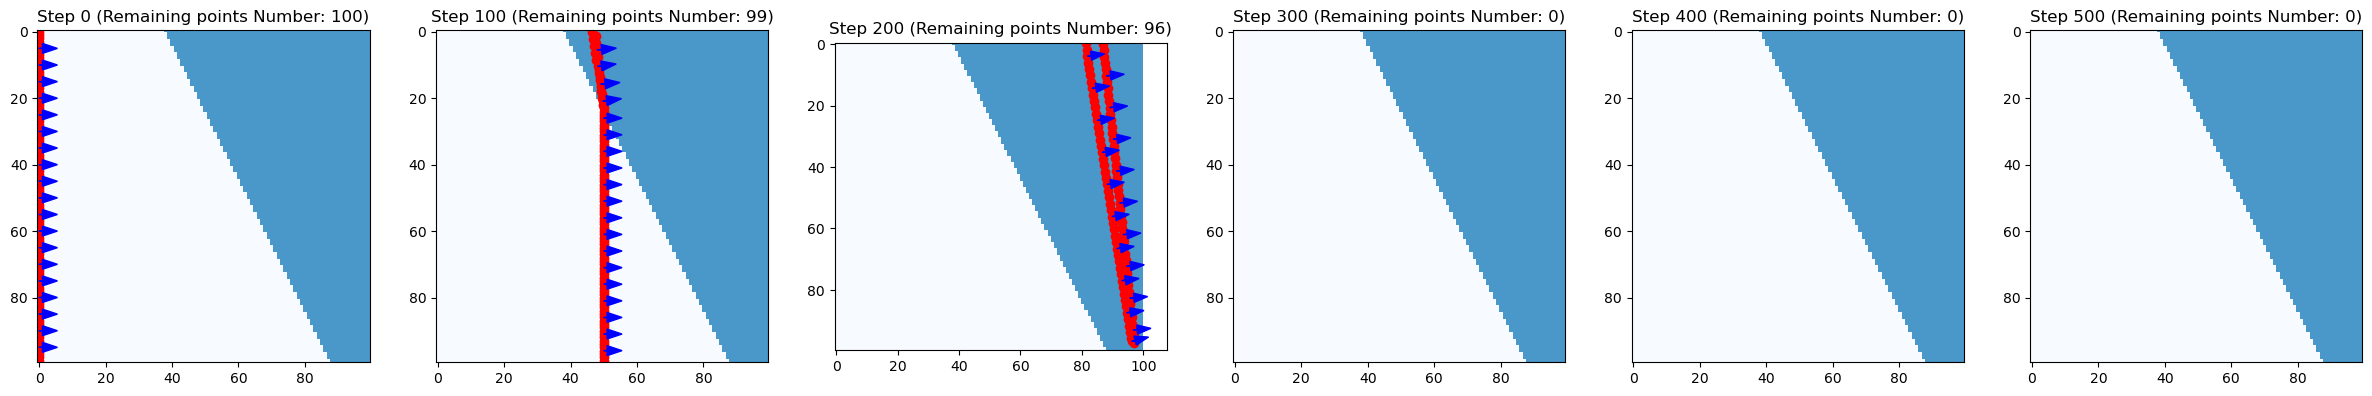

In [23]:
def update_wavefront(pos, dir, IOR, delta_t):
    new_pos = []
    new_dir = []
    grad_x_ior, grad_y_ior = compute_gradients(IOR)
    for (x, y), (vx, vy) in zip(pos, dir):
        if 0 <= int(y) < IOR.shape[0] and 0 <= int(x) < IOR.shape[1]:
            n = IOR[int(y), int(x)]
            
            # x_i+1 = x_i + delta_t * v_i / n^2
            # v_i+1 = v_i + delta_t * grad_n / n
            # calculate the new position
            new_x = x + delta_t * (vx / (n**2))
            new_y = y + delta_t * (vy / (n**2))

            # calculate the new direction
            nx = grad_x_ior[int(y), int(x)]
            ny = grad_y_ior[int(y), int(x)]
            new_vx = vx + delta_t * (nx / n)
            new_vy = vy + delta_t * (ny / n)

            new_pos.append((new_x, new_y))
            new_dir.append((new_vx, new_vy))

        else:
            pass

    return new_pos, new_dir

def simulate_wavefront_propagation(cur_IOR, inital_wavefront_pos, initial_wavefront_dir, num_steps=200, delta_t=1.0):
    wavefront_pos_list = [inital_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    for _ in range(num_steps):
        wavefront_positions, wavefront_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_IOR, delta_t)
        wavefront_pos_list.append(wavefront_positions)
        wavefront_dir_list.append(wavefront_directions)
    return wavefront_pos_list, wavefront_dir_list

def visualize_wavefront_propagation(wavefront_pos_list, wavefront_dir_list, cur_IOR, num_show_images=5):
    # show the wavefront propagation in num_show_images steps between 0 and num_steps
    num_show_images = [i for i in range(0, num_steps + 1, num_steps // num_show_images)]

    plt.figure(figsize=(5 * len(num_show_images), 5))
    for i in num_show_images:
        plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
        plt.imshow(cur_IOR, cmap='Blues', vmin=1.0, vmax=1.5)
        plt.scatter([p[0] for p in wavefront_pos_list[i]], [p[1] for p in wavefront_pos_list[i]], color='red')
        for j, (x, y) in enumerate(wavefront_pos_list[i]):
            if j != 0 and j % 5 == 0:
                plt.arrow(x, y, wavefront_dir_list[i][j][0], wavefront_dir_list[i][j][1], color='blue', head_width=3)        
        plt.title(f'Step {i} (Remaining points Number: {len(wavefront_pos_list[i])})')
    plt.show()


for key, value in ior_field_dict.items():
    wavefront_pos_list, wavefront_dir_list = simulate_wavefront_propagation(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)
    value['pos'] = wavefront_pos_list
    value['dir'] = wavefront_dir_list
    visualize_wavefront_propagation(wavefront_pos_list, wavefront_dir_list, value['ior'], num_show_images)

## 3. Calculate irradiance

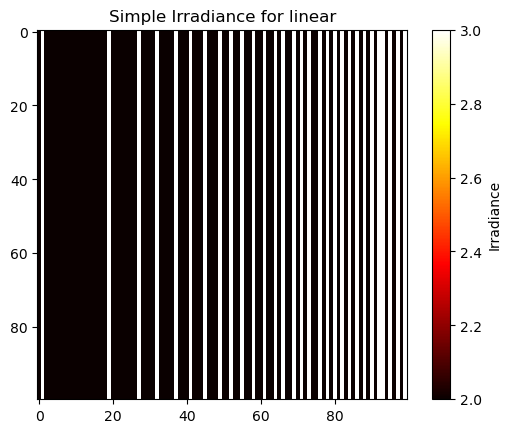

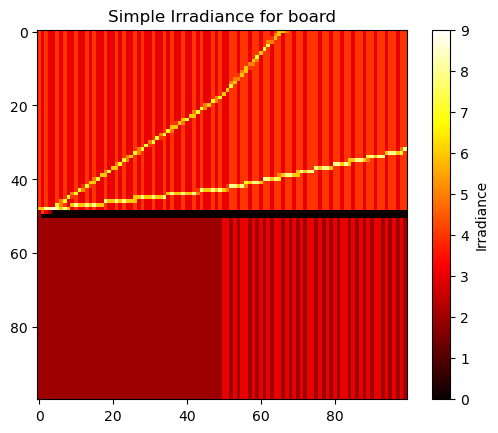

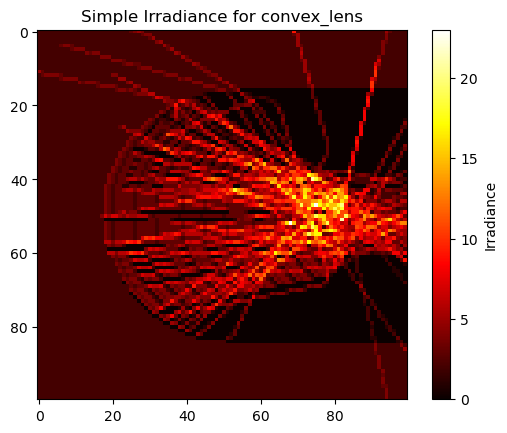

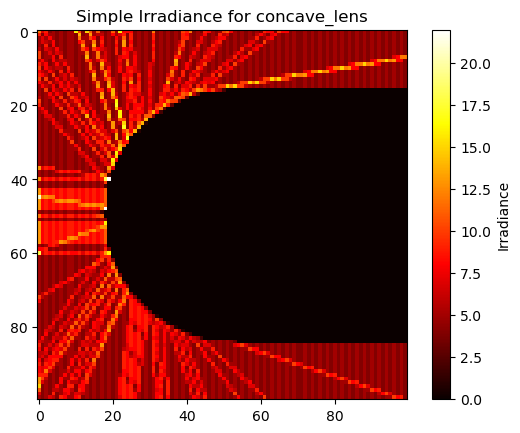

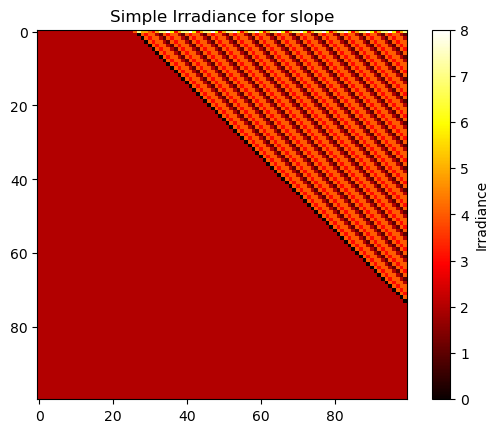

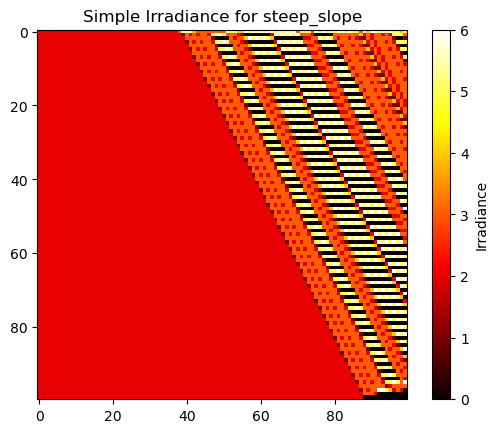

In [24]:
def compute_simple_irradiance(wavefront_pos_list, field_size):
    irradiance = np.zeros((field_size, field_size))
    for pos_list in wavefront_pos_list:
        for x, y in pos_list:
            if 0 <= int(y) < field_size and 0 <= int(x) < field_size:
                irradiance[int(y), int(x)] += 1

    return irradiance

def visualize_irradiance(irradiance, title):
    plt.figure()
    plt.imshow(irradiance, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Irradiance')
    plt.title(title)
    plt.show()

for key, value in ior_field_dict.items():
    value['irradiance'] = compute_simple_irradiance(value['pos'], field_size)
    visualize_irradiance(value['irradiance'], f'Simple Irradiance for {key}')

## 4. Store irradiance into quad tree

In [25]:
type(ior_field_dict['linear']['irradiance'])

numpy.ndarray

In [37]:
class Node:
    def __init__(self, val: int, isLeaf: bool, topLeft=None, topRight=None, bottomLeft=None, bottomRight=None):
        self.val = val
        self.isLeaf = isLeaf
        self.topLeft = topLeft
        self.topRight = topRight
        self.bottomLeft = bottomLeft
        self.bottomRight = bottomRight
    
    def __repr__(self):
        # call a recursive function to print the tree
        return self._repr_recursive()

    def _repr_recursive(self, _depth=0, _max_depth=2):
        indent = "  " * _depth
        if self.isLeaf:
            return f"{indent}Node(val={self.val}, isLeaf={self.isLeaf})"
        else:
            if _depth >= _max_depth:
                return f"{indent}Node(val={self.val}, isLeaf={self.isLeaf}, ...)"
            return (f"{indent}Node(val={self.val}, isLeaf={self.isLeaf},\n"
                    f"-{self._repr_recursive_child(self.topLeft, _depth + 1, _max_depth)},\n"
                    f"-{self._repr_recursive_child(self.topRight, _depth + 1, _max_depth)},\n"
                    f"-{self._repr_recursive_child(self.bottomLeft, _depth + 1, _max_depth)},\n"
                    f"-{self._repr_recursive_child(self.bottomRight, _depth + 1, _max_depth)})")

    def _repr_recursive_child(self, child, _depth, _max_depth):
        if child is None:
            return "  " * _depth + "None"
        else:
            return child._repr_recursive(_depth, _max_depth)

class QuadTree:
    def __init__(self, threshold: int):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
        

    def construct(self, grid: np.ndarray) -> None:
        self.root = self.helper(grid, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def helper(self, grid: np.ndarray, i: int, j: int, size: int) -> Node:
        if self.allSame(grid, i, j, size):
            return Node(grid[i, j], True)

        halfSize = size // 2
        topLeft = self.helper(grid, i, j, halfSize)
        topRight = self.helper(grid, i, j + halfSize, halfSize)
        bottomLeft = self.helper(grid, i + halfSize, j, halfSize)
        bottomRight = self.helper(grid, i + halfSize, j + halfSize, halfSize)
        # if all children are leaves and have the same value, then this node can be a leaf
        if topLeft.isLeaf and topRight.isLeaf and bottomLeft.isLeaf and bottomRight.isLeaf and \
           topLeft.val == topRight.val == bottomLeft.val == bottomRight.val:
            return Node(topLeft.val, True)
        else:
            node = Node(0, False, topLeft, topRight, bottomLeft, bottomRight)
            return node

    def allSame(self, grid: np.ndarray, i: int, j: int, size: int) -> bool:
        minVal = np.min(grid[i:i+size, j:j+size])
        maxVal = np.max(grid[i:i+size, j:j+size])
        return maxVal - minVal <= self.threshold

    def query(self, x: int, y: int) -> int:
        return self._query(self.root, 0, 0, self.grid_size, x, y)

    def _query(self, root: Node | None, i: int, j: int, size: int, x: int, y: int) -> int:
        if root is None:
            return -1
        
        if root.isLeaf:
            return root.val

        halfSize = size // 2
        if x < i + halfSize:
            if y < j + halfSize:
                return self._query(root.bottomLeft, i, j, halfSize, x, y)
            else:
                return self._query(root.topLeft, i, j + halfSize, halfSize, x, y)
        else:
            if y < j + halfSize:
                return self._query(root.bottomRight, i + halfSize, j, halfSize, x, y)
            else:
                return self._query(root.topRight, i + halfSize, j + halfSize, halfSize, x, y)
            

In [27]:
def visualize_quad_tree(quad_tree: QuadTree, x: float, y: float, size: float):
    plt.figure(figsize=(12, 12))
    if quad_tree.root is None:
        return
    
    def visualize_node(node: Node | None, x: float, y: float, size: float):
        if node is None:
            return
        if node.isLeaf:
            rect = patches.Rectangle((x, y), size, size, linewidth=1, edgecolor='black', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x + size / 2, y + size / 2, str(int(node.val)), ha='center', va='center')
        else:
            halfSize = size / 2
            visualize_node(node.topLeft, x, y + halfSize, halfSize)
            visualize_node(node.topRight, x + halfSize, y + halfSize, halfSize)
            visualize_node(node.bottomLeft, x, y, halfSize)
            visualize_node(node.bottomRight, x + halfSize, y, halfSize)
    visualize_node(quad_tree.root, x, y, size)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.title('Quad Tree Visualization')
    plt.show()

def count_nodes(quad_tree: QuadTree) -> int:
    def count_nodes_recursive(node: Node | None) -> int:
        if node is None:
            return 0
        
        count = 1
        count += count_nodes_recursive(node.topLeft)
        count += count_nodes_recursive(node.topRight)
        count += count_nodes_recursive(node.bottomLeft)
        count += count_nodes_recursive(node.bottomRight)
        
        return count
    
    return count_nodes_recursive(quad_tree.root)

def calculate_memory_usage(quad_tree: QuadTree) -> int:
    def calculate_memory_usage_recursive(node: Node | None) -> int:
        if node is None:
            return 0
        
        memory = sys.getsizeof(node)
        
        # Recursively calculate the memory usage of the children nodes
        memory += calculate_memory_usage_recursive(node.topLeft)
        memory += calculate_memory_usage_recursive(node.topRight)
        memory += calculate_memory_usage_recursive(node.bottomLeft)
        memory += calculate_memory_usage_recursive(node.bottomRight)
        
        return memory
    
    return calculate_memory_usage_recursive(quad_tree.root)

2.0
Number of nodes: 157
Memory Usage: 8792 bytes
| NumPy Storage Usage: 80000 bytes


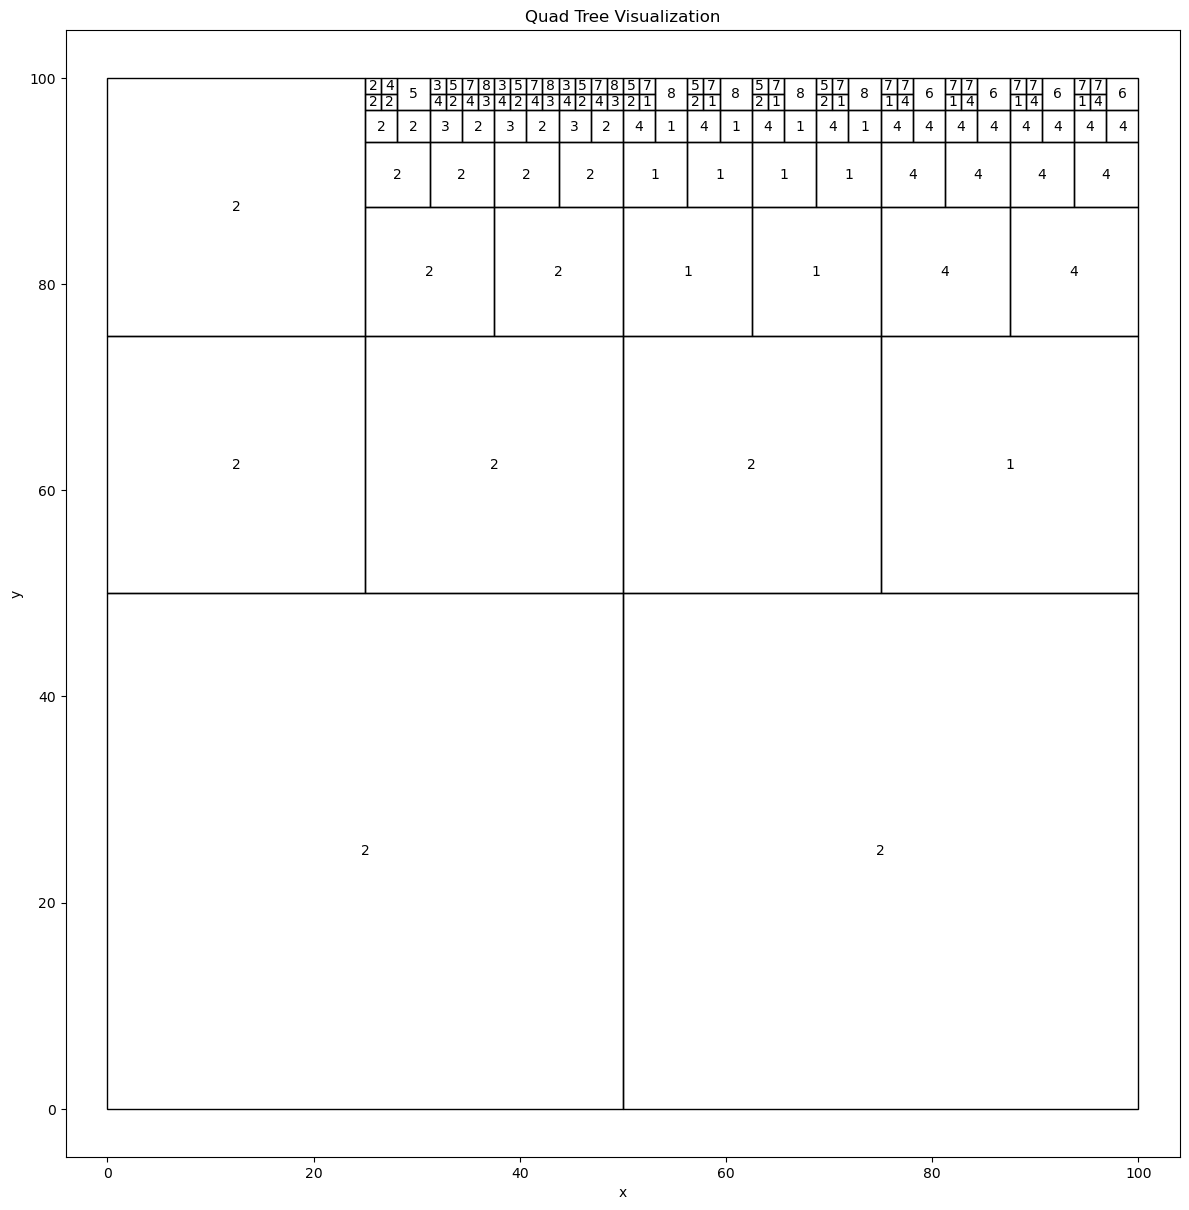

In [38]:
tester = 'slope'
test_irradiance = ior_field_dict[tester]['irradiance']
quad_tree = QuadTree(threshold=5)
quad_tree.construct(test_irradiance)

value = quad_tree.query(0, 99)
print(value)

node_count = count_nodes(quad_tree)
print(f"Number of nodes: {node_count}")

memory_usage = calculate_memory_usage(quad_tree)
print(f"Memory Usage: {memory_usage} bytes")
print(f"| NumPy Storage Usage: {test_irradiance.nbytes} bytes")


visualize_quad_tree(quad_tree, 0, 0, quad_tree.grid_size)


In [39]:
quad_tree.root

Node(val=0, isLeaf=False,
-  Node(val=0, isLeaf=False,
-    Node(val=2.0, isLeaf=True),
-    Node(val=0, isLeaf=False, ...),
-    Node(val=2.0, isLeaf=True),
-    Node(val=2.0, isLeaf=True)),
-  Node(val=0, isLeaf=False,
-    Node(val=0, isLeaf=False, ...),
-    Node(val=0, isLeaf=False, ...),
-    Node(val=2.0, isLeaf=True),
-    Node(val=1.0, isLeaf=True)),
-  Node(val=2.0, isLeaf=True),
-  Node(val=2.0, isLeaf=True))